In [2]:
!nvidia-smi

Mon Jul 14 19:12:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.20             Driver Version: 570.133.20     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          Off |   00000000:5D:00.0 Off |                    0 |
| N/A   24C    P0             72W /  700W |       0MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
!export CUDA_LAUNCH_BLOCKING=1
!export TORCH_USE_CUDA_DSA=1

In [4]:
%pip install unsloth
%pip install huggingface_hub datasets accelerate
%pip install transformers
%pip install --upgrade jupyter ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
%%bash
export PATH="$HOME/.local/bin:$PATH"

In [6]:
from unsloth import FastLanguageModel
import os
from unsloth.chat_templates import get_chat_template, standardize_data_formats

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-Math-7B",
    load_in_4bit=False,
    dtype="bfloat16",
    max_seq_length=2048,  
    token=os.getenv("HF_TOKEN"),
)

model.gradient_checkpointing_disable()

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "qwen2.5",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.2: Fast Qwen2 patching. Transformers: 4.53.1.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.189 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
from datasets import load_dataset, concatenate_datasets
from typing import Dict, Any

def normalize_dataset(ds, problem_key: str, solution_key: str):
    """Normalize dataset to have consistent Problem and Solution columns"""
    return ds.map(lambda x: {
        "Problem": str(x[problem_key]),
        "Solution": str(x[solution_key])
    })

# Load datasets
aime_train = load_dataset("Maxwell-Jia/AIME_2024", split="train")
aime_val = load_dataset("AI-MO/aimo-validation-aime", split="train") 
deepscaler = load_dataset("agentica-org/DeepScaleR-Preview-Dataset", split="train")

print(aime_train.num_rows)
print(aime_val.num_rows)
print(deepscaler.num_rows)

# Normalize each dataset
aime_train_norm = normalize_dataset(aime_train, "Problem", "Solution")
aime_val_norm = normalize_dataset(aime_val, "problem", "solution")
deepscaler_norm = normalize_dataset(deepscaler, "problem", "solution")

# Combine into single dataset
combined_dataset = concatenate_datasets([
    aime_train_norm,
    aime_val_norm, 
    deepscaler_norm
])

print(f"Combined dataset size: {combined_dataset.num_rows}")
print(f"Sample entry:\n{combined_dataset[100]}")



30
90
40315
Combined dataset size: 40435
Sample entry:
{'ID': None, 'Problem': 'Rectangles $ABCD$ and $EFGH$ are drawn such that $D,E,C,F$ are collinear. Also, $A,D,H,G$ all lie on a circle. If $BC=16$,$AB=107$,$FG=17$, and $EF=184$, what is the length of $CE$?', 'Solution': 'We use simple geometry to solve this problem. \n\nWe are given that $A$, $D$, $H$, and $G$ are concyclic; call the circle that they all pass through circle $\\omega$ with center $O$. We know that, given any chord on a circle, the perpendicular bisector to the chord passes through the center; thus, given two chords, taking the intersection of their perpendicular bisectors gives the center. We therefore consider chords $HG$ and $AD$ and take the midpoints of $HG$ and $AD$ to be $P$ and $Q$, respectively. \n\nWe could draw the circumcircle, but actually it does not matter for our solution; all that matters is that $OA=OH=r$, where $r$ is the circumradius. \nBy the Pythagorean Theorem, $OQ^2+QA^2=OA^2$. Also, $OP^2+PH

In [8]:
def formatting_prompts_func(examples):
    inputs  = examples["Problem"]
    targets = examples["Solution"]
    texts = [
        f"Question:\n{prob}\nSolution:\n{sol}"
        for prob, sol in zip(inputs, targets)
    ]
    return {
        "text": texts
    }

dataset = combined_dataset.map(formatting_prompts_func, batched=True)



In [9]:
print(dataset[131]["text"])

Question:
A rectangular yard contains two flower beds in the shape of congruent isosceles right triangles. The remainder of the yard has a trapezoidal shape, as shown. The parallel sides of the trapezoid have lengths $15$ and $25$ meters. What fraction of the yard is occupied by the flower beds?

[asy]
unitsize(2mm); defaultpen(linewidth(.8pt));
fill((0,0)--(0,5)--(5,5)--cycle,gray);
fill((25,0)--(25,5)--(20,5)--cycle,gray);
draw((0,0)--(0,5)--(25,5)--(25,0)--cycle);
draw((0,0)--(5,5));
draw((20,5)--(25,0));
[/asy]
Solution:
1. **Identify the dimensions of the triangles:**
   The problem states that the yard contains two congruent isosceles right triangles and the parallel sides of the trapezoidal remainder are $15$ meters and $25$ meters. The difference in length between the parallel sides of the trapezoid is $25 - 15 = 10$ meters. Since the triangles are congruent and isosceles right triangles, each triangle's legs are equal to half of this difference:
   \[
   \text{Leg length of ea

In [10]:
split = dataset.train_test_split(test_size=0.1)
train_ds, val_ds = split["train"], split["test"]

print(f"Train dataset size: {train_ds.num_rows}")
print(f"Validation dataset size: {val_ds.num_rows}")

Train dataset size: 36391
Validation dataset size: 4044


In [11]:
from trl import SFTConfig, SFTTrainer

sft_config = SFTConfig(
    dataset_text_field="text",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=1e-5,
    optim="adamw_8bit",
    bf16=True,
    eval_strategy="steps",
    eval_steps=50,
)

In [12]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 8,           # Larger = higher accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    bias = "none",
    random_state = 3407,
)

Unsloth 2025.7.2 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [13]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    args=sft_config,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    formatting_func=formatting_prompts_func,
)

Unsloth: Tokenizing ["text"] (num_proc=224):   0%|          | 0/36391 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=224):   0%|          | 0/4044 [00:00<?, ? examples/s]

In [14]:
trainer.train()



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 36,391 | Num Epochs = 3 | Total steps = 1,707
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 4 x 1) = 64
 "-____-"     Trainable parameters = 20,185,088 of 7,635,801,600 (0.26% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
50,0.875900,0.800129
100,0.731200,0.782389
150,0.612600,0.677991
200,0.571800,0.604744
250,0.570500,0.587906
300,0.472700,0.580563
350,0.624500,0.576102
400,0.417800,0.572808
450,0.563800,0.570232
500,0.513600,0.568222


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=1707, training_loss=0.55651207724788, metrics={'train_runtime': 9826.9667, 'train_samples_per_second': 11.11, 'train_steps_per_second': 0.174, 'total_flos': 3.484869745767202e+18, 'train_loss': 0.55651207724788})

In [15]:
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


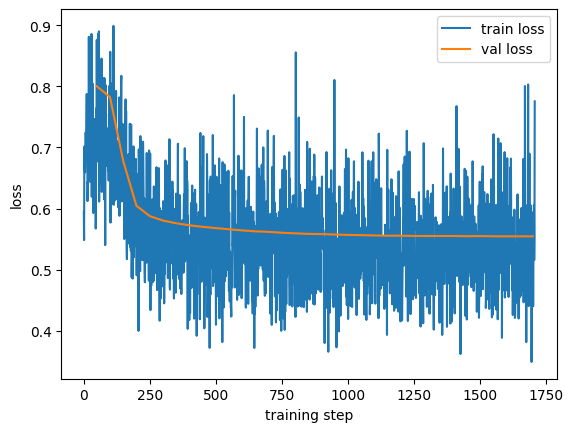

In [16]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

# train entries only
train_entries = [
    x for x in history
    if "loss" in x and "eval_loss" not in x
]
train_steps  = [e["step"] for e in train_entries]
train_losses = [e["loss"] for e in train_entries]

# eval entries only
eval_entries = [
    x for x in history
    if "eval_loss" in x
]
eval_steps  = [e["step"] for e in eval_entries]
eval_losses = [e["eval_loss"] for e in eval_entries]

plt.plot(train_steps, train_losses, label="train loss")
plt.plot(eval_steps,  eval_losses,  label="val loss")
plt.xlabel("training step")
plt.ylabel("loss")
plt.legend()
plt.show()



In [17]:
from peft import PeftModel

peft_model: PeftModel = trainer.model

merged_model = peft_model.merge_and_unload()

merged_model.eval()
merged_model.half()

output_dir = "theamrelhady/finetuned-qwen-2.5-math-7b-v2"
merged_model.save_pretrained(output_dir, safe_serialization=True)
tokenizer.save_pretrained(output_dir)

from huggingface_hub import create_repo,upload_folder
import os

repo_id = "theamrelhady/finetuned-qwen-2.5-math-7b-v2"
create_repo(repo_id, exist_ok=True)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    path_in_repo="",                 
    token=os.getenv("HF_TOKEN"),
)

  0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/theamrelhady/finetuned-qwen-2.5-math-7b-v2/commit/17068cd7f95ecc54b04e240a853a4fa949a040c3', commit_message='Upload folder using huggingface_hub', commit_description='', oid='17068cd7f95ecc54b04e240a853a4fa949a040c3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/theamrelhady/finetuned-qwen-2.5-math-7b-v2', endpoint='https://huggingface.co', repo_type='model', repo_id='theamrelhady/finetuned-qwen-2.5-math-7b-v2'), pr_revision=None, pr_num=None)

In [18]:
base_model, base_tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-Math-7B",
    load_in_4bit=False,
    dtype="bfloat16",
    max_seq_length=2048,  
    token=os.getenv("HF_TOKEN"),
)

==((====))==  Unsloth 2025.7.2: Fast Qwen2 patching. Transformers: 4.53.1.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.189 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
messages = [
    {"role": "user", "content": """Problem: The 9 members of a baseball team went to an ice cream parlor after their game. Each player had a singlescoop cone of chocolate, vanilla, or strawberry ice cream. At least one player chose each flavor, and the number of players who chose chocolate was greater than the number of players who chose vanilla, which was greater than the number of players who chose strawberry. Let $N$ be the number of different assignments of flavors to players that meet these conditions. Find the remainder when $N$ is divided by 1000."""}
]

In [20]:


base_tokenizer = get_chat_template(
    base_tokenizer,
    chat_template = "qwen2.5",
)

base_inputs = base_tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    tokenize=True,
    return_dict=True,
).to("cuda")


total_window = base_model.config.max_position_embeddings
prompt_len = base_inputs.input_ids.shape[-1]
max_gen = total_window - prompt_len

print("Base model:")

_ = base_model.generate(
    **base_inputs,            # give the model more room
    max_new_tokens=max_gen,
    streamer=TextStreamer(base_tokenizer, skip_prompt=True),
)





# Now this will work:
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    tokenize=True,
    return_dict=True,
).to("cuda")

from transformers import TextStreamer


print("Finetuned model:")

_ = model.generate(
    **inputs,            # give the model more room
    max_new_tokens=max_gen,
    streamer=TextStreamer(tokenizer, skip_prompt=True),
)


Base model:


NameError: name 'TextStreamer' is not defined